First, Lets download some packages:

In [1]:
!pip install prettytable
#!pip install wmi
!pip install matplotlib

Now, Lets import them and some more libraries:

In [2]:
import psutil
import time
import numpy as np
from subprocess import call
from prettytable import PrettyTable
from datetime import datetime
import matplotlib.pyplot as plt
#import wmi

If we need an anti virus scan:

In [3]:
# check to scan

import subprocess

# This is our shell command, executed by Popen.

def run_antivirus():
    completed = subprocess.run(["powershell", "-Command", "Start-MpScan -ScanType QuickScan"], capture_output=True)
    if completed.returncode == 0:
        isScanDone = True
    else:
        raise Exception("Anti virus scan didn't work")
    return completed


Some helpful functions:

In [4]:
def calc_time_interval():
    time = datetime.now() - starting_time
    return time.total_seconds()

# [ [x1, y1] [x2, y2] [x3,y3]] to [x1 x2 x3] and [y1 y2 y3]
def split_to_xy(arr):
    x,y = zip(*arr)
    return x, y

def draw_graph(x, y, y_name):
    # plotting the points
    plt.plot(x, y)

    # naming the x axis
    plt.xlabel('Time')
    # naming the y axis
    plt.ylabel(y_name)

    # giving a title to my graph
    plt.title('My first graph!')

    # function to show the plot
    plt.show()

    

In [5]:
need_scan = True
isScanDone = not need_scan
SCAN_TIME = 30 # 30 minutes
starting_time = datetime.now()
ANTIVIRUS_PROCESS_NAME = "MsMpeng"
SYSTEM_IDLE_PROCESS_NAME = "System Idle Process"

Now, Lets gather some data and display it in tables.
Also, enter the sample into a data structure in order to display it as a graph:

In [6]:
battery_available_precent = []
used_total_memory = []
used_memory_by_antivirus = []
used_total_cpu = []
used_cpu_by_antivirus = []
used_total_disk = []
used_disk_by_antivirus = []
used_total_IO = []
used_IO_by_antivirus = []

# ***Battery:*** 

In [7]:
#c = wmi.WMI()
#t = wmi.WMI(moniker = "//./root/wmi")

# Run an infinite loop to constantly monitor the system
def print_battery_stat():
    print("==============================Process Monitor\
        ======================================")

    # Fetch the battery information
    battery = psutil.sensors_battery().percent
    print("Battery Available: %d " % (battery,) + "%")
    battery_available_precent.append([calc_time_interval(), battery])

    batts1 = c.CIM_Battery(Caption='Portable Battery')
    for i, b in enumerate(batts1):
        print('Battery %d Design Capacity: %d mWh' % (i, b.DesignCapacity or 0))

    batts = t.ExecQuery('Select * from BatteryFullChargedCapacity')
    for i, b in enumerate(batts):
        print('Battery %d Fully Charged Capacity: %d mWh' %
              (i, b.FullChargedCapacity))

    batts = t.ExecQuery('Select * from BatteryStatus where Voltage > 0')
    for i, b in enumerate(batts):
        print('Voltage:           ' + str(b.Voltage))
        print('RemainingCapacity: ' + str(b.RemainingCapacity))

        if b.Charging:
            raise Exception("Unplug charging cable during measurements!")


# ***Network:*** 

In [8]:
def print_network_stat():
    print("----Networks----")
    table = PrettyTable(['Network', 'Status', 'Speed'])
    for key in psutil.net_if_stats().keys():
        name = key
        up = "Up" if psutil.net_if_stats()[key].isup else "Down"
        speed = psutil.net_if_stats()[key].speed
        table.add_row([name, up, speed])
    print(table)

# ***Memory:*** 

In [9]:
def create_total_memory_table():
    print("----Memory----")
    memory_table = PrettyTable(["Total(GB)", "Used(GB)",
                                "Available(GB)", "Percentage"])
    vm = psutil.virtual_memory()
    memory_table.add_row([
        f'{vm.total / 1e9:.3f}',
        f'{vm.used / 1e9:.3f}',
        f'{vm.available / 1e9:.3f}',
        vm.percent
    ])
    used_total_memory.append([calc_time_interval(), f'{vm.used / 1e9:.3f}'])
    print(memory_table)

# ***Disk:*** 

In [10]:
def create_total_disk_table():
    print("----Disk----")
    disk_table = PrettyTable(["Total(GB)", "Used(GB)",
                              "Available(GB)", "Percentage"])
    disk_stat = psutil.disk_usage('/')
    disk_table.add_row([
        f'{disk_stat.total / 1e9:.3f}',
        f'{disk_stat.used / 1e9:.3f}',
        f'{disk_stat.free / 1e9:.3f}',
        disk_stat.percent
    ])
    used_total_disk.append([calc_time_interval(), f'{disk_stat.used / 1e9:.3f}'])
    print(disk_table)

# ***Disk I/O:*** 

In [11]:
# TODO: i/o data is cumulative. maybe we should subtract that from initial i/o data (when the python program starts)
def create_current_disk_io_table():
    print("----Disk I/O----")
    disk_table = PrettyTable(["read_count", "write_count",
                              "read_bytes(GB)", "write_bytes(GB)"])
    disk_io_stat = psutil.disk_io_counters()
    disk_table.add_row([
        disk_io_stat.read_count,
        disk_io_stat.write_count,
        f'{disk_io_stat.read_bytes / 1e9:.3f}',
        f'{disk_io_stat.write_bytes / 1e9:.3f}'
    ])
    print(disk_table)


# ***All Processes:*** 

In [12]:
# TODO: i/o data is cumulative. maybe we should subtract that from initial i/o data (when the python program starts)
def create_process_table():
    print("----Processes----")
    process_table = PrettyTable(['PID', 'PNAME',
                                 'CPU', 'NUM THREADS', 'MEMORY(MB)', 'MEMORY(%)', 'read_count', 'write_count', 'read_bytes', 'write_bytes'])

    proc = []
    # get the pids from last which mostly are user processes
    for p in psutil.process_iter():
        try:
            # trigger cpu_percent() the first time which leads to return of 0.0
            p.cpu_percent()
            proc.append(p)

        except Exception as e:
            pass

    # sort by cpu_percent
    top = {}
    time.sleep(0.1)
    for p in proc:
        # trigger cpu_percent() the second time for measurement
        top[p] = p.cpu_percent() / psutil.cpu_count()

    top_list = sorted(top.items(), key=lambda x: x[1])
    top10 = top_list[-20:]
    top10.reverse()

    for p, cpu_percent in top10:

        # While fetching the processes, some of the subprocesses may exit
        # Hence we need to put this code in try-except block
        if p.name() == SYSTEM_IDLE_PROCESS_NAME:
                used_total_cpu.append([calc_time_interval(), float(f'{100 - cpu_percent:.2f}')])
        elif need_scan and p.name() == ANTIVIRUS_PROCESS_NAME:
                used_cpu_by_antivirus.append([calc_time_interval(), f'{cpu_percent:.2f}'])
        try:
            # oneshot to improve info retrieve efficiency
            with p.oneshot():
                disk_io = p.io_counters()
                process_table.add_row([
                    str(p.pid),
                    p.name(),
                    f'{cpu_percent:.2f}' + "%",
                    p.num_threads(),
                    f'{p.memory_info().rss / 1e6:.3f}', # TODO: maybe should use uss instead rss?
                    round(p.memory_percent(),2),
                    disk_io.read_count,
                    disk_io.write_count,
                    disk_io.read_bytes,
                    disk_io.write_bytes
                ])
            

        except Exception as e:
            pass
    print(process_table)


# ***CPU:*** 

In [13]:
# TO DO: calculate the total cpu consumption

Now, Lets run the main:

In [14]:
def main_program():
    condition = not isScanDone if need_scan else (datetime.now() - start_time <= timedelta(minutes=SCAN_TIME))
    print (condition)
    while condition:
        print("befor")
        create_total_disk_table()
        print("after disk")
        create_current_disk_io_table()
        print("after io")
        create_total_memory_table()
        print("after memory")
        create_process_table()
        print("after process")
        
        # Create a 1 second delay
        time.sleep(0.5)
        

In [15]:
# create 2 processes, one to run the code and one to run the antivirus.
from multiprocessing import Process

mainP = Process(target=main_program, args=())
mainP.start()

if need_scan:
    scanP = Process(target=run_antivirus, args=())
    scanP.start()
    scanP.join()

In [16]:
#print_battery_stat()
starting_time = datetime.now()
create_total_disk_table()

for i in range(5):

    # Clear the screen using a bash command
    #call('clear')


    # Fetch the Network information - relevant?
    # print_network_stat()

    create_current_disk_io_table()

    # Fetch the memory information
    create_total_memory_table()


    # Fetch the 10 processes from available processes that has the highest cpu usage
    create_process_table()

    # Create a 1 second delay
    time.sleep(1)

#print_battery_stat()


----Disk----
+-----------+----------+---------------+------------+
| Total(GB) | Used(GB) | Available(GB) | Percentage |
+-----------+----------+---------------+------------+
|  500.966  | 180.328  |    320.638    |    36.0    |
+-----------+----------+---------------+------------+
----Disk I/O----
+------------+-------------+----------------+-----------------+
| read_count | write_count | read_bytes(GB) | write_bytes(GB) |
+------------+-------------+----------------+-----------------+
|  6824401   |   2281388   |    286.704     |     110.694     |
+------------+-------------+----------------+-----------------+
----Memory----
+-----------+----------+---------------+------------+
| Total(GB) | Used(GB) | Available(GB) | Percentage |
+-----------+----------+---------------+------------+
|   16.889  |  9.117   |     7.772     |    54.0    |
+-----------+----------+---------------+------------+
----Processes----
+-------+---------------------+--------+-------------+------------+----------

+-------+---------------------+--------+-------------+------------+-----------+------------+-------------+------------+-------------+
|  PID  |        PNAME        |  CPU   | NUM THREADS | MEMORY(MB) | MEMORY(%) | read_count | write_count | read_bytes | write_bytes |
+-------+---------------------+--------+-------------+------------+-----------+------------+-------------+------------+-------------+
|   0   | System Idle Process | 89.11% |      8      |   0.008    |    0.0    |     0      |      0      |     0      |      0      |
|  4316 |      python.exe     | 9.57%  |      21     |  105.288   |    0.62   |    2437    |     247     |  17884744  |    451195   |
|  4032 |      chrome.exe     | 0.41%  |      17     |  477.884   |    2.83   |  1202506   |   1120382   | 1968417020 |  387840784  |
| 17336 |      chrome.exe     | 0.00%  |      17     |   41.845   |    0.25   |    2324    |     558     |  1510044   |    109488   |
| 17332 |  RuntimeBroker.exe  | 0.00%  |      3      |   19.80

Print all saved data:

In [17]:
print("-------------- Battery data --------------")
print(battery_available_precent)
print("-------------- Total Memory data ---------------")
print(used_total_memory)
print("-------------- Antivirus Memory data -------------")
print(used_memory_by_antivirus)
print("-------------- Total CPU data -------------")
print(used_total_cpu)
print("-------------- Antivirus CPU data -----------")
print(used_cpu_by_antivirus)
print("-------------- Total Disk data ---------------")
print(used_total_disk)
print("-------------- Antivirus Disk data ------------")
print(used_disk_by_antivirus)

-------------- Battery data --------------
[]
-------------- Total Memory data ---------------
[[0.0, '9.117'], [1.920254, '9.112'], [3.820855, '9.108'], [5.704299, '9.099'], [7.584432, '9.096']]
-------------- Antivirus Memory data -------------
[]
-------------- Total CPU data -------------
[[0.86273, 16.01], [2.77096, 11.16], [4.660786, 10.89], [6.544766, 12.45], [8.44103, 11.49]]
-------------- Antivirus CPU data -----------
[]
-------------- Total Disk data ---------------
[[0.0, '180.328']]
-------------- Antivirus Disk data ------------
[]


Display all graphs:

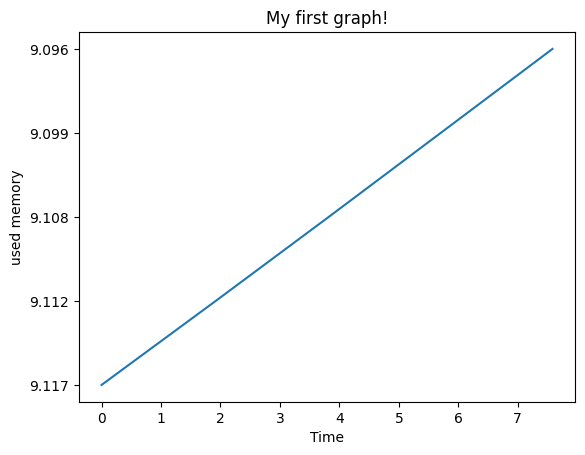

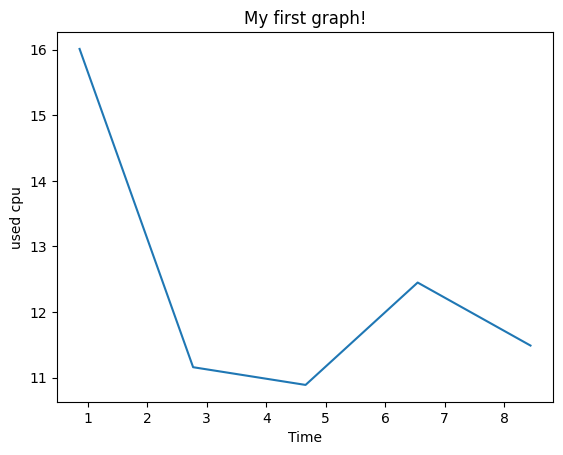

In [18]:
x, y = split_to_xy(used_total_memory)
draw_graph(x, y, "used memory")
x, y = split_to_xy(used_total_cpu)
draw_graph(x, y, "used cpu")